In [14]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor

In [15]:
df = pd.read_csv('./combined.csv', usecols=['MC', 'STATID', 'SDATE', 'Y', 'M', 'D', 'TEMP_°C', 'pH', 'TSS_mg/L', 'COND_mS/m', 'Ca_meq/L', 'Mg_meq/L', 'Na_meq/L', 'K_meq/L', 'ALK_meq/L', 'Cl_meq/L', 'SO4_meq/L', 'NO32_mg/L', 'NH4N_mg/L', 'TOTP_mg/L', 'DO_mg/L', 'CODMN_mg/L'])


# only keep 48 stations in 48_station.txt
# according with column 'STATID' in df
with open('./48_stations.txt', 'r') as f:
    stations = f.readlines()
stations = [x.strip() for x in stations]
df = df[df['STATID'].isin(stations)]

/tmp/ipykernel_1968851/3403362453.py:1: DtypeWarning: Columns (12,14,18,21,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./combined.csv', usecols=['MC', 'STATID', 'SDATE', 'Y', 'M', 'D', 'TEMP_°C', 'pH', 'TSS_mg/L', 'COND_mS/m', 'Ca_meq/L', 'Mg_meq/L', 'Na_meq/L', 'ALK_meq/L', 'Cl_meq/L',  'NO32_mg/L', 'NH4N_mg/L', 'TOTP_mg/L', 'DO_mg/L', 'CODMN_mg/L'])


In [16]:
df = df.replace(' ', np.nan)
df = df.replace('\n', np.nan)
df = df.replace('-', np.nan)
df = df.replace('<0.4', np.nan)
df = df.replace('<0.40', np.nan)
df = df.replace('<0.001', np.nan)
df = df.replace('', np.nan)
df = df.replace('No water', np.nan)

df['DO_mg/L'] = pd.to_numeric(df['DO_mg/L'], errors='coerce')

df['TEMP_°C'] = df['TEMP_°C'].astype(float)
# df['TSS_mg'] = df['TSS_mg'].astype(float)
df['Na_meq/L'] = df['Na_meq/L'].astype(float)
df['K_meq/L'] = df['K_meq/L'].astype(float)
df['Cl_meq/L'] = df['Cl_meq/L'].astype(float)
# df['TOTN_mg/L'] = df['TOTN_mg/L'].astype(float)
df['CODMN_mg/L'] = df['CODMN_mg/L'].astype(float)
df['DO_mg/L'] = df['DO_mg/L'].astype(float)
# df['EC_CAT/EC'] = df['EC_CAT/EC'].astype(float)
# df['EC_DIFF'] = df['EC_DIFF'].astype(float)
df['TSS_mg/L'] = df['TSS_mg/L'].astype(float)

In [17]:
df.shape

(12288, 20)

In [18]:
outlier_ranges = {
    "TEMP_°C": (18, 32),
    "TSS_mg/L": (0, 360),
    "COND_mS/m": (0, 30),
    "Ca_meq/L": (0, 2),
    "pH": (6, 9),
    "Na_meq/L": (0, 1),
    "Mg_meq/L": (0, 0.8),
    "ALK_meq/L": (0, 2.5),
    "Cl_meq/L": (0, 1.2),
    "K_meq/L": (0, 0.15),
    "SO4_meq/L": (0, 0.7),
    "NO32_mg/L": (0, 0.8),
    "NH4N_mg/L": (0, 0.4),
    "TOTP_mg/L": (0, 0.4),
    "CODMN_mg/L": (0, 10),
    "DO_mg/L": (0, 15)
}

In [19]:
df.columns

Index(['MC', 'STATID', 'SDATE', 'Y', 'M', 'D', 'TEMP_°C', 'pH', 'TSS_mg/L',
       'COND_mS/m', 'Ca_meq/L', 'Mg_meq/L', 'Na_meq/L', 'ALK_meq/L',
       'Cl_meq/L', 'NO32_mg/L', 'NH4N_mg/L', 'TOTP_mg/L', 'DO_mg/L',
       'CODMN_mg/L'],
      dtype='object')

In [20]:
def plot_outlier_range(df, outlier_ranges):
    plt.figure(figsize=(16, 10))
    for i, column in enumerate(df.columns[6:], 1):
        plt.subplot(4,4, i)
        sns.histplot(df[column], kde=True, bins=30)
        plt.axvline(outlier_ranges[column][0], color='r', linestyle='--')
        plt.axvline(outlier_ranges[column][1], color='r', linestyle='--')
        plt.title(column)
        plt.grid(True)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig('outlier_range.pdf')

In [21]:
df.isna().sum()

MC               0
STATID           0
SDATE            0
Y                0
M                0
D                0
TEMP_°C       1153
pH              58
TSS_mg/L       421
COND_mS/m       32
Ca_meq/L      1140
Mg_meq/L      1134
Na_meq/L      2157
ALK_meq/L       31
Cl_meq/L      1123
NO32_mg/L       94
NH4N_mg/L       97
TOTP_mg/L       84
DO_mg/L        667
CODMN_mg/L     150
dtype: int64

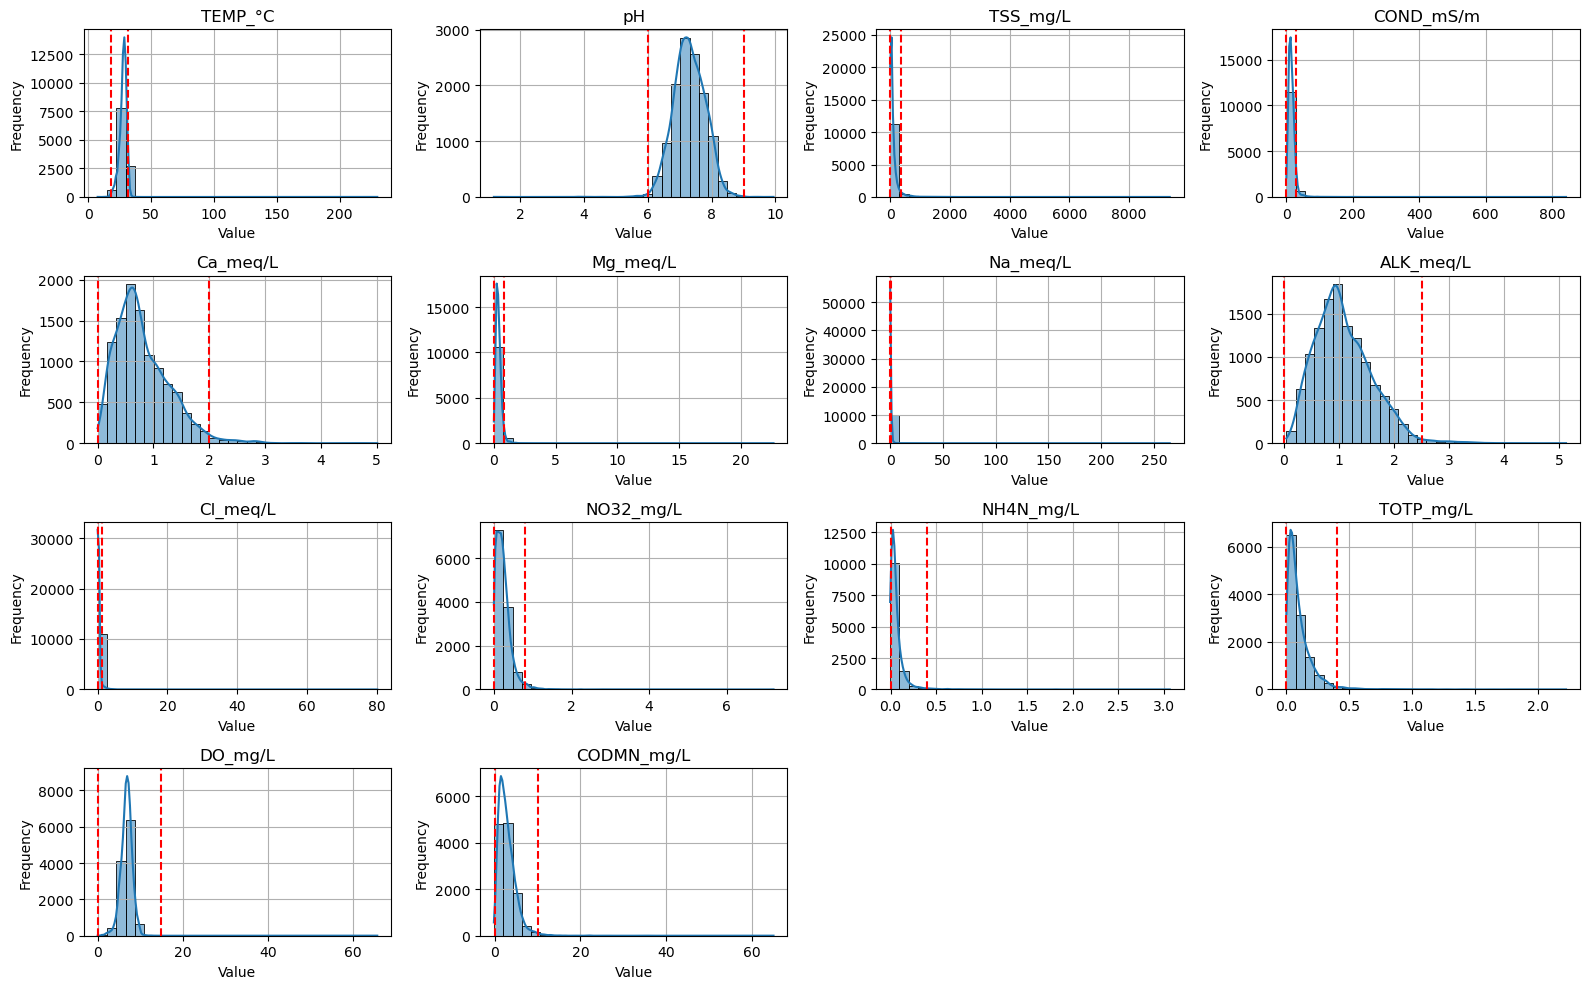

In [22]:
plot_outlier_range(df, outlier_ranges)

In [23]:
# drop outliers
df_drop = df.copy()
for col, (low, high) in outlier_ranges.items():
    df_drop = df_drop[(df_drop[col] >= low) & (df_drop[col] <= high)]

df_drop.shape


(6345, 20)

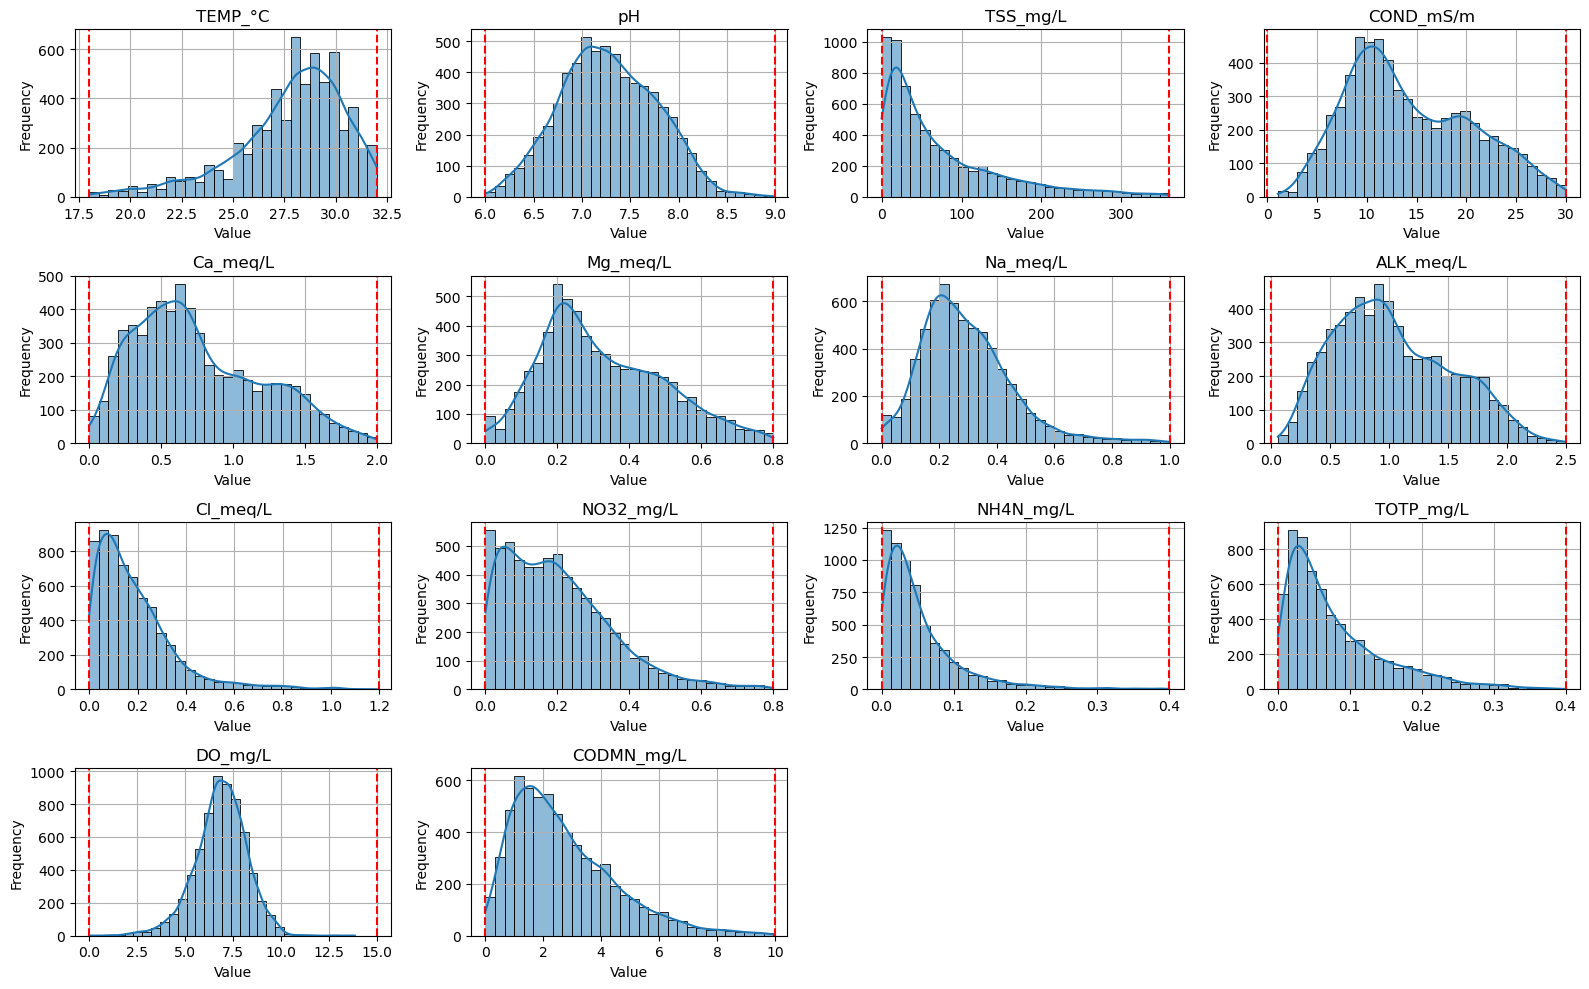

In [24]:
plot_outlier_range(df_drop, outlier_ranges)

In [25]:
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6345 entries, 2 to 29614
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MC          6345 non-null   object 
 1   STATID      6345 non-null   object 
 2   SDATE       6345 non-null   object 
 3   Y           6345 non-null   int64  
 4   M           6345 non-null   int64  
 5   D           6345 non-null   int64  
 6   TEMP_°C     6345 non-null   float64
 7   pH          6345 non-null   float64
 8   TSS_mg/L    6345 non-null   float64
 9   COND_mS/m   6345 non-null   float64
 10  Ca_meq/L    6345 non-null   float64
 11  Mg_meq/L    6345 non-null   float64
 12  Na_meq/L    6345 non-null   float64
 13  ALK_meq/L   6345 non-null   float64
 14  Cl_meq/L    6345 non-null   float64
 15  NO32_mg/L   6345 non-null   float64
 16  NH4N_mg/L   6345 non-null   float64
 17  TOTP_mg/L   6345 non-null   float64
 18  DO_mg/L     6345 non-null   float64
 19  CODMN_mg/L  6345 non-null   flo

In [73]:
df_drop.to_csv('df_drop.csv', index=False)

In [53]:
df.columns

Index(['MC', 'STATID', 'SDATE', 'Y', 'M', 'D', 'TEMP_°C', 'pH', 'TSS_mg/L',
       'COND_mS/m', 'Ca_meq/L', 'Mg_meq/L', 'Na_meq/L', 'K_meq/L', 'ALK_meq/L',
       'Cl_meq/L', 'SO4_meq/L', 'NO32_mg/L', 'NH4N_mg/L', 'TOTP_mg/L',
       'DO_mg/L', 'CODMN_mg/L'],
      dtype='object')

Max 80.106
Min 0.0


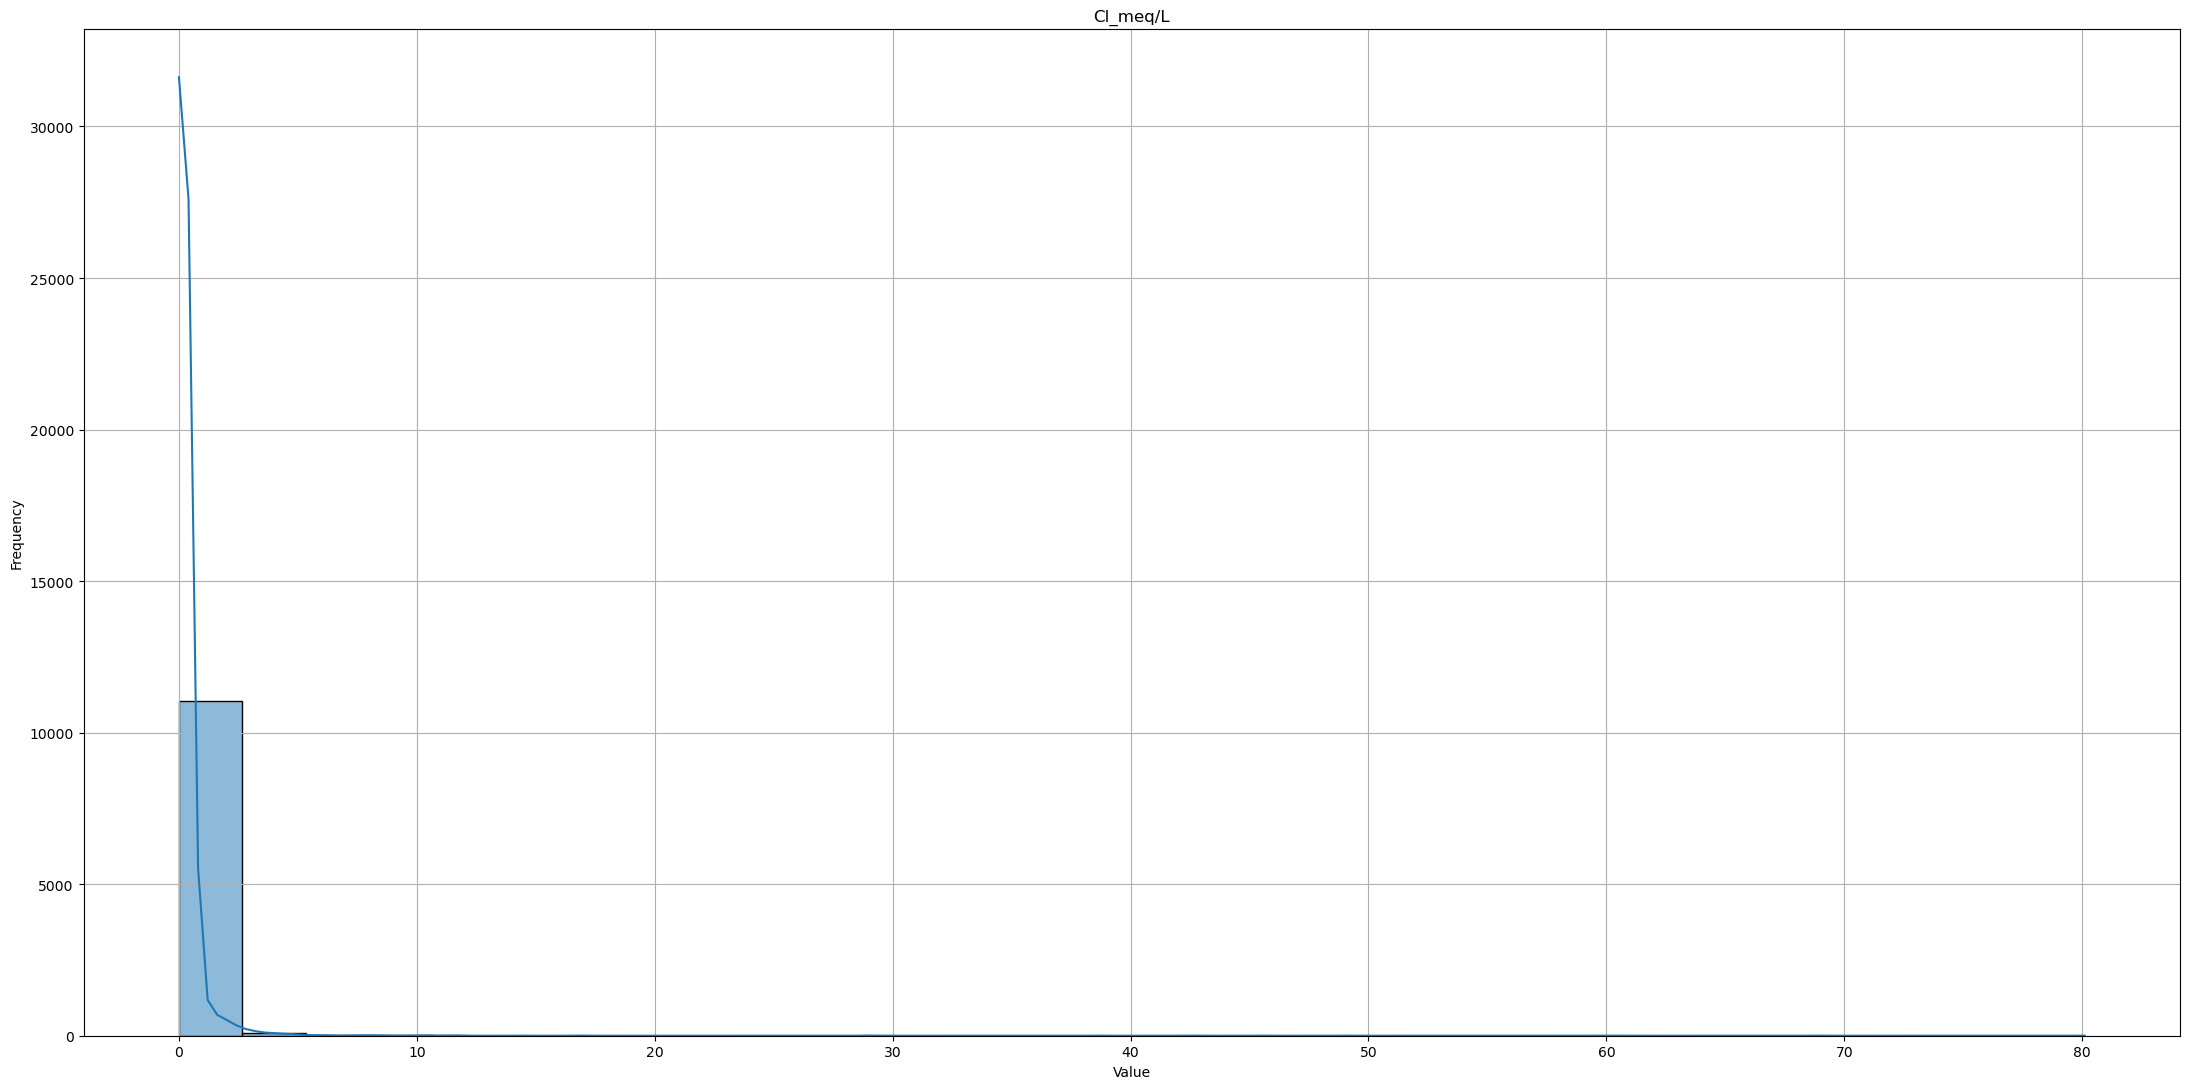

In [54]:
df_plot_distribution = df.drop(['MC', 'STATID', 'SDATE', 'Y', 'M', 'D'], axis=1)
col = 'Cl_meq/L'
print('Max', df_plot_distribution[col].max())
print('Min', df_plot_distribution[col].min())
plt.figure(figsize=(22, 11))
sns.histplot(df_plot_distribution[col], kde=True, bins=30)
plt.title(col)
plt.grid(True)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.tight_layout()

In [55]:
df.shape

(12288, 22)

In [56]:
df.isna().sum()

MC               0
STATID           0
SDATE            0
Y                0
M                0
D                0
TEMP_°C       1153
pH              58
TSS_mg/L       421
COND_mS/m       32
Ca_meq/L      1140
Mg_meq/L      1134
Na_meq/L      2157
K_meq/L       2154
ALK_meq/L       31
Cl_meq/L      1123
SO4_meq/L     1119
NO32_mg/L       94
NH4N_mg/L       97
TOTP_mg/L       84
DO_mg/L        667
CODMN_mg/L     150
dtype: int64